<a href="https://colab.research.google.com/github/yvrjsharma/Keras-edition-deux/blob/main/Keras_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working With Keras: A Deep Dive

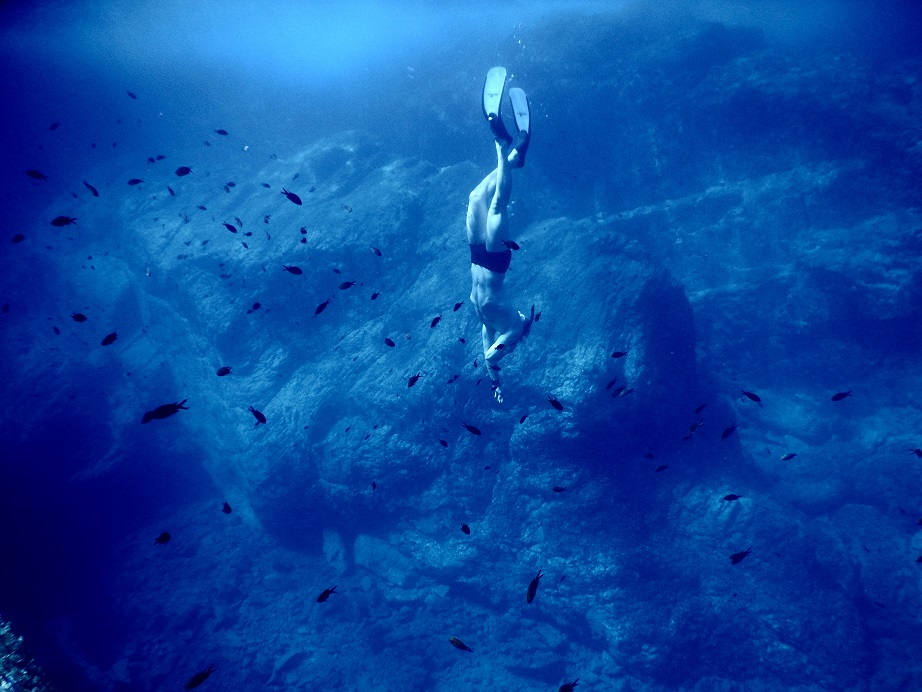

Photo by <a href="https://unsplash.com/@marco_assmann?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Marco Assmann</a> on <a href="https://unsplash.com/s/photos/deep-dive?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

This chapter explains how you can build models using Keras techniques like Sequential class, Functional API and also model subclassing. It also touches upon Keras *Callbacks* and *TensorBoard*. 

What we have used so far in the journey - Sequential model, Dense Layers, model.compile(), model.fit() for traininig, model.evaluate() for ebaluating and model.predict() for inference. In this chapter/blogpost you will get to learn everything you need to handle advanced deep learning use cases like computer vision, NLP, generative deep learning *etc.* Lets Go!



## Ways to build Keras models

There are different ways or APIs to build Keras models and different ways to train thse models as well.
* *Sequential model API* - acts like a python list or simple stack of layers, very easy to use.
* *Fucntional API* - Graph like model architectures, easy as well as flexible to use.
* *Model subclassing* - you write everything from scratch, gives you more control, hoever more chances to make errors. 

### Sequential model

Layer weights are created only when the input shape is known to a model. This happens when you call a model's build() function with input shape. 

In [1]:
#Building basic sequential model
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(64,"relu"),
                          layers.Dense(10, "softmax")])

#another way
model = keras.Sequential(name="example_model")
model.add(layers.Dense(64, activation="relu", name="first_layer"))
model.add(layers.Dense(10, activation="softmax", name="second_layer"))

#Error - ValueError: Weights for model sequential_5 have not yet been created.
#uncomment and run
#model.weights

Lets build the model by telling it the shape of its inputs. Note that you can't *summarize* a model using summary() funtcion until it is being build first. Summary() is acctually a very good model in debugging your model workflow when there are layers that modify input shapes in complex ways. -

In [ ]:
#not telling the no. of samples right now, thus None
#telling the dimension of each sample, which is 3 i this eg.
model.build(input_shape=(None,3))
#This will run this time
model.weights

#Notice weights shape as (3,64) in the output bias would be (64,)
#next layer is softmax (10), thus weights shape is (64,10) and bias would be (10,)

In [3]:
#Summary of a netwrok comes handy in debugging
#Notice first layer output is shaped (None,64), it would have been (60000,64) in case of MNIST eg. in previous post/chapters
#Similarly you can understand the output shape for second or softmax layer- (None,10)
model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 64)                256       
                                                                 
 second_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


You can't call summary() function over a model untless you build it and declare input shape while doing so. However there is another way, in this we build Sequential model on the fly by declaring the input shape in advance as shown in below code piece -



In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, "relu"))

#runs without error 
#using summary to check the shape on the fly
model.summary()

In [6]:
#adding more layers on the fly and checking how shape of model changes
model.add(layers.Dense(10, "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### Functional API

* Sequential API can only be used to express models which have single input and single output, and which can be expressed using linear fashion oflayers in a list format.
* Most of the Keras model in the wild use Functional API. They have multiple inputs as well as outputs and a nonlinear topology.

Lets implement the above model in Functional API way -

In [9]:
#Start by declaring Input
inputs = keras.Input(shape=(3,), name="input")
#inpputs is a symbolic tensor - one with no data but has rest of specifications
print(inputs.shape, inputs.dtype)

#next we create a layer and call it on inputs
#all keras layers can be called on real data tensors as well as symbolic tensors
#result will be an another symbolic tensor
features = layers.Dense(64, "relu")(inputs)
print(features.shape)

#getting outputs
outputs = layers.Dense(10, "softmax")(features)

#instantiating the model by using Model constructor with inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

#displaying final summary
model.summary()

(None, 3) <dtype: 'float32'>
(None, 64)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                256       
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


* To implement model with multiple inputs and outputs, you need to declare all different inputs (as symbolic tensors) first, then you declare a layer that combines (or concat) all input tensos into a single one, and then similarly declare multiple outputs. Lastly you have to instantiate Model class  with all inputs and outputs as lists.

* Lets look at below example to understand this better --

In [14]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

* To train this type of a model, you can follow the same procedure as in Sequential API case, except providing all inputs and outputs in form of lists this time

In [15]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step - loss: 6.7199 - priority_loss: 0.3369 - department_loss: 6.3830 - priority_mean_absolute_error: 0.5062 - department_accuracy: 0.1711
